# 2010RF12 close approaches prediction
Written by Jackey Fang<br>
<br>
**Last Update**<br>
2026-02-22

# Imports

In [16]:
import requests
import numpy as np
import rebound
import warnings
import matplotlib.pyplot as plt
import os
import contextlib
from astropy.time import Time
from erfa.core import ErfaWarning

# API and Data Extraction

In [17]:
def fetch_data(asteroid_id):
    """
    Get orbital elements and covariance matrix of asteroid from each agencies
    """
    print(f"Fetching Data for {asteroid_id}")
    
    # NASA SBDB API
    nasa_url = f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={asteroid_id}&cov=mat&full-prec=true"
    print("Fetching from NASA SBDB...")
    nasa_req = requests.get(nasa_url)
    
    if nasa_req.status_code == 200:
        nasa_data = nasa_req.json()
        
    # Grab the labels
        nasa_labels = nasa_data['orbit']['covariance']['labels'][:6]
        
        # Covariance Matrix
        nasa_covariance = np.array(nasa_data['orbit']['covariance']['data'], dtype=float)
        nasa_covariance_6 = nasa_covariance[:6, :6]
        
        # Build dict
        elements_list = nasa_data['orbit']['elements']
        elements_dict = {item['name']: float(item['value']) for item in elements_list}

        # Key map
        name_map = {'node': 'om', 'peri': 'w'}

        nasa_elements = []
        for label in nasa_labels:
            # Get the correct lookup key
            lookup_key = name_map.get(label, label)
            nasa_elements.append(elements_dict[lookup_key])
            
        nasa_elements = np.array(nasa_elements, dtype=float)
        nasa_epoch_jd = float(nasa_data['orbit']['epoch'])

        print(f"NASA Data Retrieved in format: {nasa_labels}")
    else:
        print("NASA fetch failed.")
        return None, None, None, None, None, None, None, None
    
    # ESA NEO API
    esa_id = asteroid_id.replace(" ", "")
    esa_url = f"https://neo.ssa.esa.int/PSDB-portlet/download?file={esa_id}.eq0"
    print("\nFetching from ESA NEO Portal...")
    esa_req = requests.get(esa_url)
    
    if esa_req.status_code == 200 and "END_OF_HEADER" in esa_req.text:
        esa_covariance = []
        esa_elements = []
        esa_labels = ['a', 'e', 'i', 'om', 'w', 'ma']
        
        for line in esa_req.text.splitlines():
            clean_line = line.strip()
            if clean_line.startswith('MJD'):
                mjd = float(clean_line.split()[1])
                esa_epoch_jd = mjd + 2400000.5
            elif clean_line.startswith('KEP'):
                esa_elements = np.array([float(x) for x in clean_line.split()[1:7]])
            elif clean_line.startswith('EQU'):
                esa_elements = np.array([float(x) for x in clean_line.split()[1:7]])
                esa_labels = ['a', 'h', 'k', 'p', 'q', 'lon']
            elif clean_line.startswith('COV'):
                esa_covariance.extend([float(x) for x in clean_line.split()[1:]])
                
        # Reconstruct the matrix
        esa_covariance_6 = np.zeros((6, 6))
        idx = 0
        for i in range(6):
            for j in range(i + 1):
                esa_covariance_6[i, j] = esa_covariance[idx]
                esa_covariance_6[j, i] = esa_covariance[idx] 
                idx += 1
                
        print(f"ESA Data Retrieved in format: {esa_labels}")
    else:
        print("ESA fetch failed.")
        return nasa_elements, nasa_covariance_6, nasa_labels, nasa_epoch_jd, None, None, None, None

    return nasa_elements, nasa_covariance_6, nasa_labels, nasa_epoch_jd, esa_elements, esa_covariance_6, esa_labels, esa_epoch_jd

In [18]:
asteroid = "2010 RF12"
nasa_ele, nasa_cov, nasa_lbl, nasa_epoch, esa_ele, esa_cov, esa_lbl, esa_epoch = fetch_data(asteroid)

Fetching Data for 2010 RF12
Fetching from NASA SBDB...
NASA Data Retrieved in format: ['e', 'q', 'tp', 'node', 'peri', 'i']

Fetching from ESA NEO Portal...
ESA Data Retrieved in format: ['a', 'h', 'k', 'p', 'q', 'lon']


# Virtual Asteroids

In [19]:
def generate_virtual_asteroids(orb_elements, covariance_matrix, num_samples=1000):
    """
    Spawns virtual asteroids based on orbital uncertainty.
    """
    virtual_asteroids = np.random.multivariate_normal(
        mean = orb_elements, 
        cov = covariance_matrix, 
        size = num_samples
    )
    
    return virtual_asteroids

In [20]:
num_asteriods = 1000

# Spawn NASA
nasa_vas = generate_virtual_asteroids(nasa_ele, nasa_cov, num_asteriods)

# Spawn ESA
esa_vas = generate_virtual_asteroids(esa_ele, esa_cov, num_asteriods)

# Convert to cartesian coordinates

In [21]:
def translate_to_cartesian(vas_matrix, labels, native_epoch_jd, target_epoch_jd):
    print(f"Translating and syncing {len(vas_matrix)} asteroids to JD {target_epoch_jd}...")
    cartesian_matrix = np.zeros((len(vas_matrix), 6))
    
    # Create a single Sun to act as the gravitational anchor for the conversion
    sim = rebound.Simulation()
    sim.units = ('AU', 'days', 'Msun')
    sim.add(m=1.0)
    
    k_gauss = 0.01720209895
    delta_t = target_epoch_jd - native_epoch_jd

    for i in range(len(vas_matrix)):
        row = vas_matrix[i]
        data = {labels[j]: row[j] for j in range(6)}
        
        try:
            # NASA cometary translation
            if 'q' in labels and 'tp' in labels:
                e = data['e']
                q = data['q']
                
                # Convert Perihelion to Semi-major axis
                a = q / (1.0 - e) if e < 1.0 else q 
                
                inc = np.radians(data['i'])
                Omega = np.radians(data['node'])
                omega = np.radians(data['peri'])
                
                # Target epoch
                n = k_gauss / (a**1.5)
                m_target = n * (target_epoch_jd - data['tp'])
                m_target = m_target % (2 * np.pi)

            # ESA equinoctial translation
            elif 'h' in labels and 'k' in labels:
                a, h, k = data['a'], data['h'], data['k']
                p, q_eq = data['p'], data['q'] # 'q' here is an equinoctial angle, not perihelion
                lon = np.radians(data['lon'])
                
                e = np.sqrt(h**2 + k**2)
                inc = 2 * np.arctan(np.sqrt(p**2 + q_eq**2))
                Omega = np.arctan2(p, q_eq) if (p!=0 or q_eq!=0) else 0.0
                omega = np.arctan2(h, k) - Omega if (h!=0 or k!=0) else 0.0

                n = k_gauss / (a**1.5)
                lon_target = lon + (n * delta_t)
                m_target = lon_target - omega - Omega
                m_target = m_target % (2 * np.pi)

            # ESA standard keplerian
            else:
                a = data['a']
                e = data['e']
                inc = np.radians(data['i'])
                Omega = np.radians(data['om'])
                omega = np.radians(data['w'])
                m = np.radians(data['ma'])

                n = k_gauss / (a**1.5)
                m_target = m + (n * delta_t)
                m_target = m_target % (2 * np.pi)

            # Add the Virtual Asteroid to the REBOUND simulation
            sim.add(a=a, e=e, inc=inc, Omega=Omega, omega=omega, M=m_target, primary=sim.particles[0])
            
            # Extract the raw X, Y, Z, Vx, Vy, Vz coordinates
            p_cart = sim.particles[1]
            cartesian_matrix[i] = [p_cart.x, p_cart.y, p_cart.z, p_cart.vx, p_cart.vy, p_cart.vz]
            
            # Remove the asteroid so the simulation is empty for the next loop
            sim.remove(index=1)
            
        except Exception as e:
            pass
            
    print("Translation complete.")
    return cartesian_matrix

In [22]:
my_epoch = nasa_epoch 

nasa_cartesian = translate_to_cartesian(nasa_vas, nasa_lbl, nasa_epoch, my_epoch)
esa_cartesian = translate_to_cartesian(esa_vas, esa_lbl, esa_epoch, my_epoch)

Translating and syncing 1000 asteroids to JD 2461000.5...
Translation complete.
Translating and syncing 1000 asteroids to JD 2461000.5...
Translation complete.


In [23]:
print(f"\nExample NASA Asteroid [X, Y, Z, Vx, Vy, Vz]: \n{np.round(nasa_cartesian[0], 4)}")
print(f"Example ESA Asteroid  [X, Y, Z, Vx, Vy, Vz]: \n{np.round(esa_cartesian[0], 4)}")


Example NASA Asteroid [X, Y, Z, Vx, Vy, Vz]: 
[ 8.056e-01 -7.652e-01  7.800e-03  8.700e-03  1.340e-02 -2.000e-04]
Example ESA Asteroid  [X, Y, Z, Vx, Vy, Vz]: 
[ 8.158e-01 -7.494e-01  7.600e-03  8.500e-03  1.350e-02 -2.000e-04]


# N body sim

In [ ]:
def nbody_simulation(cartesian_matrix, start_jd, impact_date_utc):
    """
    Flies a cloud of asteroids forward in time and maps them onto the Earth's Target Plane.
    """
    # Convert the Impact Date to a Julian Date
    tca_time = Time(impact_date_utc, format='isot', scale='tdb')
    impact_jd = tca_time.jd 
    
    # Set up the Solar System
    sim = rebound.Simulation()
    sim.units = ('AU', 'days', 'Msun')
    sim.t = start_jd
    
    # Add the gravitational heavyweights
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        sim.add("Sun", date=f"JD {start_jd}")
        sim.add("399", date=f"JD {start_jd}") # Earth
        sim.add("301", date=f"JD {start_jd}") # Moon
    
    earth_idx = 1

    # Load nominal asteroid
    nominal_cart = cartesian_matrix[0]
    sim.add(x=nominal_cart[0], y=nominal_cart[1], z=nominal_cart[2], 
            vx=nominal_cart[3], vy=nominal_cart[4], vz=nominal_cart[5], 
            m=0.0)
    
    nominal_ast_idx = 3
    
    # Load the Virtual Asteroids as massless
    for cart in cartesian_matrix[1:]:
        sim.add(x=cart[0], y=cart[1], z=cart[2], 
                vx=cart[3], vy=cart[4], vz=cart[5], 
                m=0.0)
        
    # Fast forward
    sim.integrate(impact_jd)

    # Calculate the Target Plane
    earth = sim.particles[earth_idx]
    nom_ast = sim.particles[nominal_ast_idx]
    
    # Define the angle of the incoming cloud
    v_rel = np.array([nom_ast.vx - earth.vx, nom_ast.vy - earth.vy, nom_ast.vz - earth.vz])
    v_norm = v_rel / np.linalg.norm(v_rel) # The Eta axis (direction of travel)
    
    # Define the 2D cross-section axes
    k_hat = np.array([0, 0, 1])
    xi_dir = np.cross(v_norm, k_hat)
    xi_dir = xi_dir / np.linalg.norm(xi_dir)
    zeta_dir = np.cross(xi_dir, v_norm)
    
    # Map all asteroids onto the 2D plane
    b_plane_coords = np.zeros((len(cartesian_matrix), 2))
    AU_TO_EARTH_RADII = 23454.8 # Conversion factor

    # Map the nominal asteroid
    r_rel_nom = np.array([nom_ast.x - earth.x, nom_ast.y - earth.y, nom_ast.z - earth.z])
    xi_nom = np.dot(r_rel_nom, xi_dir) * AU_TO_EARTH_RADII
    zeta_nom = np.dot(r_rel_nom, zeta_dir) * AU_TO_EARTH_RADII
    b_plane_coords[0] = [xi_nom, zeta_nom]
    
    for i in range(1, len(cartesian_matrix)):
        ast = sim.particles[i + nominal_ast_idx] 
        r_rel = np.array([ast.x - earth.x, ast.y - earth.y, ast.z - earth.z])
        
        xi = np.dot(r_rel, xi_dir) * AU_TO_EARTH_RADII
        zeta = np.dot(r_rel, zeta_dir) * AU_TO_EARTH_RADII
        b_plane_coords[i] = [xi, zeta]

    warnings.simplefilter('ignore', category=ErfaWarning)

    return b_plane_coords

In [25]:
impact_date = "2095-09-05T23:45:36"

# NASA 
nasa_target_plane = nbody_simulation(nasa_cartesian, my_epoch, impact_date)

# ESA 
esa_target_plane = nbody_simulation(esa_cartesian, my_epoch, impact_date)

# Plot

In [26]:
def plot_target_plane(nasa_bplane, esa_bplane):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Plot NASA Cloud (Blue)
    plt.scatter(nasa_bplane[:, 0], nasa_bplane[:, 1], 
                s=10, alpha=0.5, color='royalblue', label='NASA')

    # Plot ESA Cloud (Orange)
    plt.scatter(esa_bplane[:, 0], esa_bplane[:, 1], 
                s=10, alpha=0.5, color='darkorange', label='ESA')

    # Draw the Earth to scale at (0,0)
    earth = plt.Circle((0, 0), 1.0, color='mediumseagreen', alpha=0.8, label='Earth')
    ax.add_patch(earth)

    # Find the maximum distance in any direction across both clouds
    all_data = np.vstack((nasa_bplane, esa_bplane))
    max_limit = np.max(np.abs(all_data)) * 1.1 # Add 10% visual padding
    
    max_limit = max(max_limit, 5.0) 
    #max_limit = 15000

    ax.set_xlim(-max_limit, max_limit)
    ax.set_ylim(-max_limit, max_limit)

    # Formatting
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    
    plt.xlabel(r'$\xi$ (Earth Radii)')
    plt.ylabel(r'$\zeta$ (Earth Radii)')
    plt.title('Target Plane of Close Approaches - 2010 RF12')
    
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right')
    
    ax.set_aspect('equal', adjustable='box') 

    plt.tight_layout()
    plt.show()

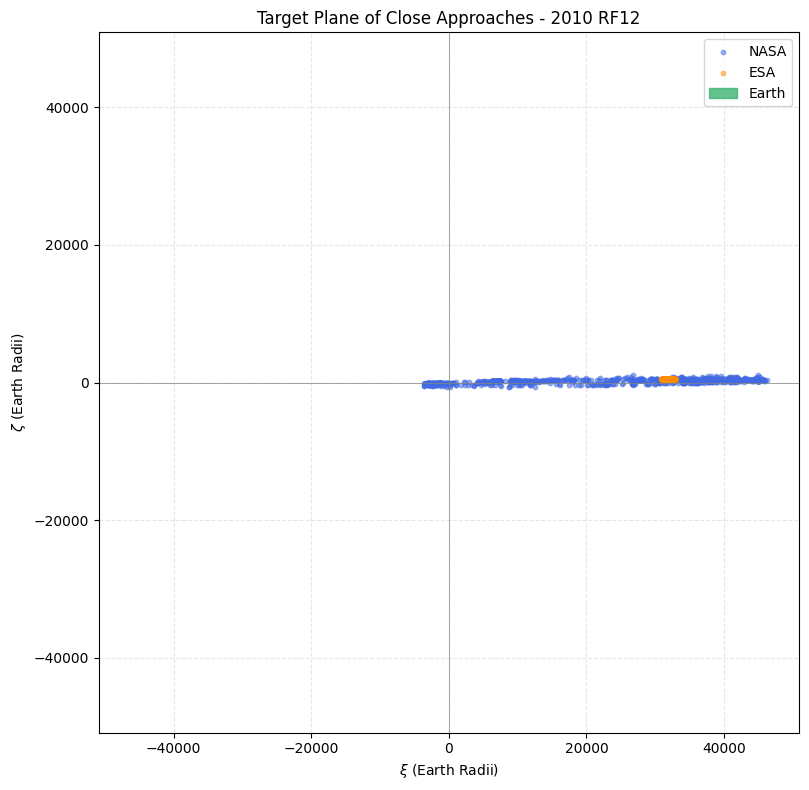

In [27]:
plot_target_plane(nasa_target_plane, esa_target_plane)

# Plot Zoom in

In [28]:
def plot_target_plane_limit(nasa_bplane, esa_bplane, x_max, x_min, y_max, y_min):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Plot NASA cloud
    plt.scatter(nasa_bplane[:, 0], nasa_bplane[:, 1], 
                s=10, alpha=0.5, color='royalblue', label='NASA')

    # Plot ESA cloud
    plt.scatter(esa_bplane[:, 0], esa_bplane[:, 1], 
                s=10, alpha=0.5, color='darkorange', label='ESA')
    
    # Medians calc
    nasa_median_xi = np.nanmedian(nasa_bplane[:, 0])
    
    esa_median_xi = np.nanmedian(esa_bplane[:, 0])

    # NASA Median
    plt.axvline(nasa_median_xi, color='blue', linestyle=':', linewidth=1.5, label='NASA Median')
    
    # ESA Median
    plt.axvline(esa_median_xi, color='red', linestyle=':', linewidth=1.5, label='ESA Median')

    # Draw the Earth to scale at (0,0)
    earth = plt.Circle((0, 0), 1.0, color='mediumseagreen', alpha=0.8, label='Earth')
    ax.add_patch(earth)

    # Set limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Formatting
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    
    plt.xlabel(r'$\xi$ (Earth Radii)')
    plt.ylabel(r'$\zeta$ (Earth Radii)')
    plt.title('Target Plane of Close Approaches - 2010 RF12')
    
    plt.grid(True, alpha=0.3, linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_aspect('equal', adjustable='box') 

    plt.tight_layout()
    plt.show()

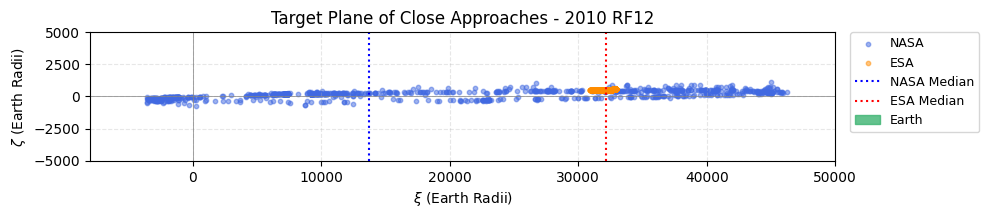

In [40]:
plot_target_plane_limit(nasa_target_plane, esa_target_plane, 50000, -8000, 5000, -5000)

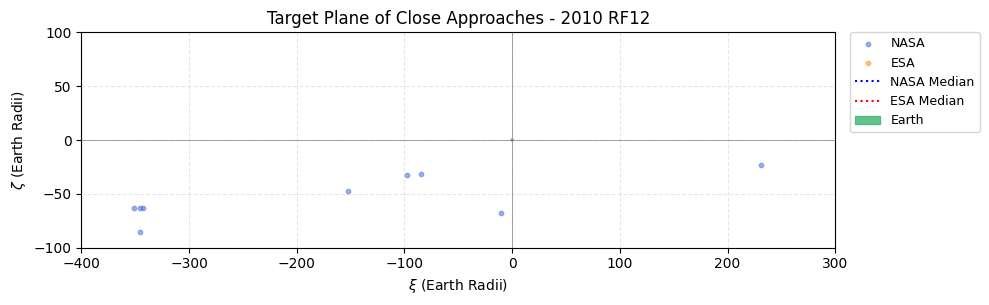

In [39]:
plot_target_plane_limit(nasa_target_plane, esa_target_plane, 300, -400, 100, -100)